# GAN Training Notebook
This notebook imports the GAN trainer class from `basic_gan_trainer.py` and all of the helper functions from `helper_functions.py`. The helper functions are used to generate training and testing data for both the generator and the discriminator, plot images from vectorized data, plot the value functions over each batch for both the generator and the discriminator, and save/recover the parameters of a given trained GAN to a .npz file (numpy data file).

In [1]:
# Import numpy and the necessary helper functions.
import numpy as np
from basic_gan_trainer import BasicGANTrainer
from helper_functions import (save_network_data, recover_network_data, 
    load_disc_train_data, load_disc_test_data, generator_input, 
    plot_subplot_images, plot_disc_value, plot_gen_value)

# Initialize a new GAN trainer class with random parameters.
trainer = BasicGANTrainer()

## Load Trained GAN
The following code block can load in data stored in a .npz file by overwriting the parameters of the newly initialized trainer. Specifically, it overwrites the values of the weight matrices with previously trained parameters and the value functions that are saved per training batch in an array with the values corresponding to the training history of the GAN that was loaded in.

In [2]:
# recover_network_data('zeros_it1_150epoch.npz', trainer)

## Generate Train and Test Data
The following code block uses the `load_disc_train_data` and the `load_disc_test_data` helper functions to load discriminator train and test data. Specifically, the data comes from EMNIST digits. The two helper functions take in one argument, a digit from 0-9, which determines which number the GAN will be trained on. It is currently set to train on 0s.

In [3]:
disc_train_data = load_disc_train_data(0)
disc_test_data = load_disc_test_data(0)
n_train_samples = disc_train_data.shape[0]
n_test_samples = disc_test_data.shape[0]

## Visualize Training Data
The following code block plots some of the training data that the GAN will learn to generate.

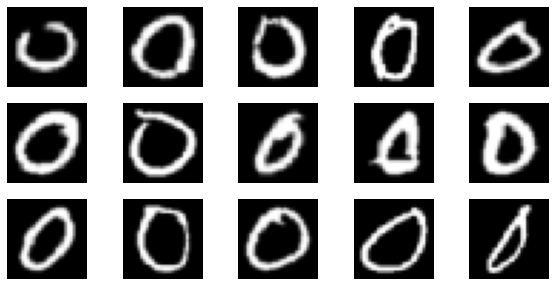

In [31]:
plot_subplot_images(disc_train_data, 3, 5, fig_size=(10,5))

## Define Training Parameters
The following code block defines the batch size that will be used to train the discriminator and generator using stochastic gradient ascent. The parameter *k* represents the number of training steps that the discriminator will take before the generator takes one training step. 

In [16]:
# Set the batch size
batch_size = 64

# Number of training steps of disc. per one training step of gen.
k = 3

# Calculate the number of baches based on total data available
num_batches = int(n_train_samples / (batch_size * k))

## Training the GAN
The following code block contains the GAN training loop. The outer loop contains the total number of epochs (full passes through all of the data) that the GAN should train for. Note that when the discriminator is being trained, the generator parameters are held constant, and when the generator is being trained, the discriminator parameters are being held constant. During each epoch, the generator and discriminator are updated in an alternate fashion.

In [ ]:
# set the number of epochs that the GAN should train for
for current_epoch in range(1, 11):
    
    for batch in range(num_batches):
        
        # Take k training steps for the discriminator
        for step_num in range(k): 
            
            # iterate through the appropriate training examples to avoid using
            # the same examples per epoch - this is a function of the batch 
            # number and the kth training step
            for train_example in range(0 + step_num * batch_size + 3 * batch * batch_size, 
                                        batch_size + step_num * batch_size + 3 * batch * batch_size):
                
                # perform a forward pass with a real training example
                trainer.disc_forward_pass(disc_train_data[train_example][np.newaxis].T)
                # if we are on the third (last) training step, update the disc. value
                if ((step_num + 1) % 3) == 0:
                    trainer.add_to_disc_value(1)
                # calculate the gradient and update the accumulator matrices
                # after one forward pass
                trainer.calc_disc_grad(1, batch_size)

                # perform a forward pass with a generated training example
                trainer.disc_forward_pass(trainer.gen_forward_pass(generator_input()))
                # if we are on the third (last) training step, update the disc. value
                if ((step_num + 1) % 3) == 0:
                    trainer.add_to_disc_value(0)
                # calculate the gradient and update the accumulator matrices
                # after one forward pass
                trainer.calc_disc_grad(0, batch_size)

            # if we are on the third (last) training step, save the disc. value
            # after the batch is done
            if ((step_num + 1) % 3) == 0:
                trainer.update_disc_value_array(batch_size)
            
            # update the weights after a single batch is finished
            trainer.update_Thetas()

        # after k training steps of the disc., perform one training step of the
        # gen. by iterating through the appropriate number of forward passes
        for _ in range(0, batch_size):

            # perform a forward pass with generated data
            trainer.disc_forward_pass(trainer.gen_forward_pass(generator_input()))
            # update the gen. value
            trainer.add_to_gen_value()
            # calculate the gen. gradient and update accumulator matrices for
            # one forward pass
            trainer.calc_gen_grad(batch_size)

        # save the gen. value after the batch is done
        trainer.update_gen_value_array(batch_size)    
        
        # update the weights after a single batch is finished
        trainer.update_Phis()
    
    # if the current epoch is a multiple of 30, save the trainer parameters to a
    # new file
    if current_epoch % 30 == 0:
        filename = "zeros_it1_{}epoch.npz".format(current_epoch)
        save_network_data(filename, trainer)

    # at the end of every epoch, print a status update
    print("Completed Epoch {}.".format(current_epoch))

## Verify Results

Perform a forward pass throught the discriminator with real test data. We should expect to see a high value for a trained discriminator.

In [28]:
trainer.disc_forward_pass(disc_test_data[2][np.newaxis].T)

array([[24654182.03670048]])

Perform a forward pass through the discriminator with generated data. We should expect to see a value lower than that for real data. The magnitude will vary depending on how trained the model is.

In [27]:
trainer.disc_forward_pass(trainer.gen_forward_pass(generator_input()))

array([[6300046.28307376]])

Plot some generated images to visualize what the generator is outputting

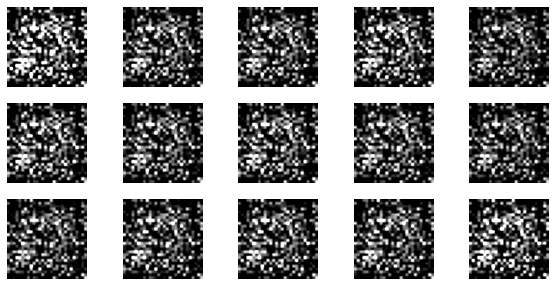

In [6]:
height = 3
width = 5
num_ims = width * height
plot_subplot_images(trainer.gen_forward_pass(generator_input(dims=(100,num_ims))).T, height, width, fig_size=(10,5))

## Value Functions

Plot the magnitude of the discriminator value function as a function of training time (batch number).

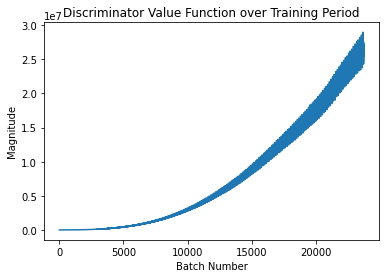

In [4]:
plot_disc_value(trainer)

Plot the magnitude of the generator value function as a function of training time (batch number). We should expect to see more variablity, with a lower magnitude than the discriminator. An increasing trend means that the generator is learning.

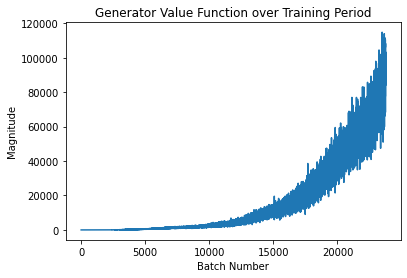

In [5]:
plot_gen_value(trainer)